In [165]:
import os
import cv2
import time
import json
import glob
import cmapy
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from utils import (
    normalize_seis,
    get_sliding_wnd_params,
    get_sliding_wnd_patches,
    window_2d,
    recover_img_from_patches,
    _downscale
)

In [166]:
class SeismicDatasetInf(Dataset):

    def __init__(self, imgs):
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img_min = img.min()
        img_max = img.max()
        if img_max - img_min != 0:
            img = (img - img_min) / (img_max - img_min)
        else:
            img = img / 255.0  #IF MIN == MAX - DEVIDE 255
        return img

In [167]:
inline = 313
inline_path = f"/data2/seismic_HYUL/dataset/thebe_processed_224_112/test/seismic/00000013.npy"

In [168]:
patch_sz = 128
step_sz = 16
overlap_sz = patch_sz - step_sz

In [169]:
merge_method = "smooth"

from models.Generator import GeneratorModel
model = GeneratorModel(input_channels=1, output_channels=1)
model_path = "/data2/generator_epoch_10.pth"

save_root = '/data2/High_resolution'
save_path = f"{save_root}/{inline}_{merge_method}"

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model.load_state_dict(torch.load(model_path))
model.to(device)

summary(model, (1, patch_sz, patch_sz))

/tmp/ipykernel_3714114/1323472915.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 128, 128]             512
            Conv2d-2        [-1, 256, 128, 128]         590,080
       BatchNorm2d-3        [-1, 256, 128, 128]             512
              ReLU-4        [-1, 256, 128, 128]               0
            Conv2d-5        [-1, 256, 128, 128]         590,080
       BatchNorm2d-6        [-1, 256, 128, 128]             512
              ReLU-7        [-1, 256, 128, 128]               0
     ResidualBlock-8        [-1, 256, 128, 128]               0
            Conv2d-9        [-1, 256, 128, 128]         590,080
      BatchNorm2d-10        [-1, 256, 128, 128]             512
             ReLU-11        [-1, 256, 128, 128]               0
           Conv2d-12        [-1, 256, 128, 128]         590,080
      BatchNorm2d-13        [-1, 256, 128, 128]             512
             ReLU-14        [-1, 256, 1

In [170]:
recovered_imgs = []
elapsed_time = 0

# Load seismic data
seismic = np.load(inline_path)
seismic = seismic

start = time.time()
Z, XL = seismic.shape  # seismic 데이터의 shape에서 Z와 XL 추출
padding, cnt = get_sliding_wnd_params((XL, Z), patch_sz, step_sz)
num_patches = cnt[0] * cnt[1]

patches = get_sliding_wnd_patches(seismic, padding, patch_sz, step_sz)
patches = patches.astype(np.float32)
patches = np.expand_dims(patches, 1)

batch_size = 4
dataset = SeismicDatasetInf(patches)
data_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=False
)

preds = []
for imgs in data_loader:
    imgs = Variable(imgs.cuda())
    outputs = model(imgs)
    outputs = _downscale(outputs, 4)
    preds.extend(outputs.detach().cpu())
    
    if len(preds) >= num_patches:
        stacked = torch.stack(preds).detach().cpu().numpy()[:num_patches]
        preds = preds[num_patches:]

        if merge_method == "smooth":
            weights = window_2d(wnd_sz=patch_sz, power=2)
            stacked = np.moveaxis(stacked, -3, -1)
            stacked = np.array([patch * weights for patch in stacked])
            stacked = stacked.reshape((cnt[1], cnt[0], patch_sz, patch_sz))
            recovered = recover_img_from_patches(stacked, (Z, XL), padding, overlap_sz)
            recovered_imgs.append(recovered)
        else:
            print('invalid merge method')

end = time.time()
elapsed_time += end - start

print(f'Total elapsed time: {elapsed_time:.2f} seconds')

Total elapsed time: 962.40 seconds


In [171]:
def min_max_normalize(image):
    min_val = image.min()
    max_val = image.max()
    normalized_image = (image - min_val) / (max_val - min_val)  # Normalizing the image
    return normalized_image

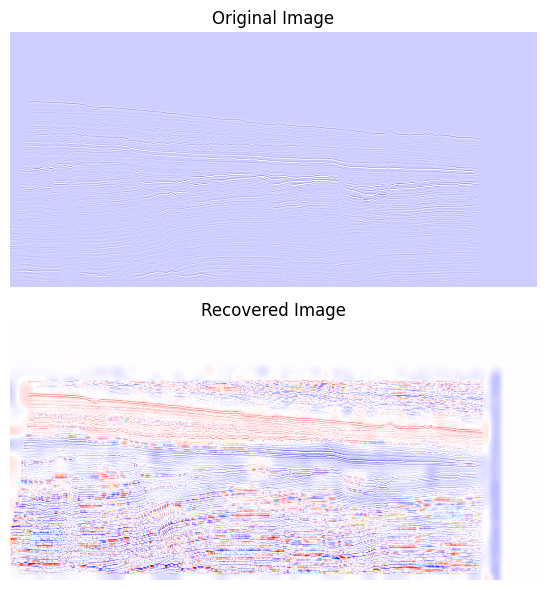

: 

In [172]:
recovered_image = recovered_imgs[0]
recovered_image = min_max_normalize(recovered_image)
plt.figure(figsize=(12, 6))
    
# Original Image
plt.subplot(2, 1, 1)
plt.title('Original Image')
plt.imshow(seismic, cmap='seismic')
plt.axis('off')

# Recovered Image
plt.subplot(2, 1, 2)
plt.title('Recovered Image')
plt.imshow(recovered_image, cmap='seismic')
plt.axis('off')
    
plt.tight_layout()
plt.show()


np.save("test.npy", recovered_image)